# <div align="center"><b> NLP2 - PRACTICO 2 </b></div>

<div align="right">📝 <em><small><font color='Gray'>Nota:</font></small></em></div>

<div align="right"> <em><small><font color='Gray'> La funcionalidad de visualización de jupyter notebooks en <a href="https://github.com/" target="_blank">github</a> es solamente un preview.</font></small></em> </div>

<div align="right"> <em><small><font color='Gray'> Para mejor visualización se sugiere utilizar el visualizador recomendado por la comunidad: <a href="https://nbviewer.org/" target="_blank">nbviewer</a></font></small></em> </div>

<div align="right"> <em><small><font color='Gray'> Puedes a acceder al siguiente enlace para ver este notebook en dicha página: <a href="https://nbviewer.org/github/brunomaso1/uba-mia/blob/mia-nlp2/mia-nlp2/Practico 2/research.ipynb">NLP2 - Practico 2</a></font></small></em> </div>

* * *

<style>
/* Limitar la altura de las celdas de salida en html */
.jp-OutputArea.jp-Cell-outputArea {
    max-height: 500px;
}
</style>

<!-- Colab -->
<!-- <div align="center"><img src="https://drive.google.com/uc?export=view&id=1QSNrTsz1hQbmZwpgwx0qpfpNtLW19Orm" width="600" alt="Figura 1: A data scientist is working on word generation using the Lord of the Rings lore. The image is dark and moody, with a focus on the scientist's computer screen. The screen displays a visualization the one ring, with a map of Middle Earth in the background. - Generada con DALL-E3"></div> -->

<div align="center"><img src="../resources/img1.jpeg" width="600" alt="Figura 1: A data scientist is sitting in front of a computer screen, intently focused on the task at hand. The room is dimly lit, with the only light coming from the computer screen. The neural network is displayed on the screen, with the data scientist working to. The nerual network is deepseek R1. - Generada con Microsoft Image Creator"></div>

<div align="center"><small><em>Figura 1: A data scientist is sitting in front of a computer screen, intently focused on the task at hand. The room is dimly lit, with the only light coming from the computer screen. The neural network is displayed on the screen, with the data scientist working to. The nerual network is deepseek R1. - Generada con Microsoft Image Creator</em></small></div>

<div align="center">✨Datos del proyecto:✨</div>

<p></p>

<div align="center">

| Subtitulo       | Practico 2 - NLP2                                                                                                                      |
| --------------- | -------------------------------------------------------------------------------------------------------------------------------------- |
| **Descrpción**  | CV Chatbot with Groq + Pinecone + Agentes                                                                                              |
| **Integrantes** | Bruno Masoller (brunomaso1@gmail.com)                                                                                                  |

</div>

🛻 <em><font color='MediumSeaGreen'>  Instalaciones: </font></em> 🛻

In [1]:
%pip install --upgrade jupyter ipywidgets
%pip install transformers torch einops
%pip install sentence-transformers
%pip install huggingface_hub[hf_xet]
%pip install langchain langchain-community langchain-pinecone pypdf langchain-groq langchain-huggingface
%pip install -U langgraph 

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


✋ <em><font color='DodgerBlue'>Importaciones:</font></em> ✋

In [2]:
# Standard Library
import os
import time
from typing import Literal

# Third-Party Libraries
from dotenv import load_dotenv
from IPython.display import Image, display

# Pinecone
from pinecone import Pinecone, ServerlessSpec

# LangChain - Document Loaders
from langchain_community.document_loaders import PyPDFLoader

# LangChain - Text Splitters
from langchain_text_splitters import RecursiveCharacterTextSplitter

# LangChain - Vector Stores
from langchain_pinecone import PineconeVectorStore

# LangChain - Embeddings
from langchain_community.embeddings import JinaEmbeddings
from langchain_core.embeddings import Embeddings

# LangChain - Chat Models
from langchain_groq import ChatGroq

# LangChain - Tools
from langchain_core.tools import tool

# LangGraph
from langgraph.prebuilt import ToolNode, create_react_agent
from langgraph.checkpoint.memory import MemorySaver

# Custom Modules
import custom_prompts as cp

🔧 <em><font color='tomato'>Configuraciones:</font></em> 🔧


In [3]:
load_dotenv()

GROQ_API_KEY = os.getenv("GROQ_API_KEY")
PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
JINA_AI_API_KEY = os.getenv("JINA_AI_API_KEY")
EMBEDDINGS_DIMENSION = 1024
EMBEDDINGS_MODEL = "jina-embeddings-v3"
GROQ_MODEL = "llama-3.3-70b-versatile"
INDEX_NAME = "nlp2-practico2"
BRUNO_CV_NAMESPACE = "nlp2-practico2-bruno-namespace"
JOSE_CV_NAMESPACE = "nlp2-practico2-jose-namespace"
CV_BRUNO_FILE_PATH = "../resources/cv_candidatos/cv-bruno-masoller.pdf"
CV_JOSE_FILE_PATH = "../resources/cv_candidatos/cv-jose-martinez.pdf"

## Consinga

- Sobre el trabajo práctico 1 (Chatbot + RAG), implementar un sistema de agentes para que responda de manera eficiente dependiendo de qué persona se está preguntando.

## Resolución

Partiendo de la base del práctico anterior: [Práctico 1](../Practico%201/research.ipynb), se implementa un sistema de agentes para que responda de manera eficiente dependiendo de qué persona se está preguntando. Para ello, se utiliza la librería [LangChain](https://python.langchain.com/docs/get_started/introduction.html) y su módulo de agentes.

El objetivo es utilizar una `tool` para buscar en el *vectorstore* correcto y luego utilizar un LLM para responder a la pregunta. Para ello, se optará por crear un *vectorstore* para cada candidato y luego el agente seleccionará el *vectorstore* correcto para buscar la información. 

Podríamos representar el RAG de la siguiente manera:

```mermaid
graph TD;
    A[HumanMessage]-->B{Responder o usar retriever?};
    B-->|retriever|C[ToolMessage];
    B-->|responder|D[AIMessage];
    C-->|contexto|B;


```

En detalle, tendríamos la siguiente secuencia de mensajes:

1. Entrada del usuario como un `HumanMessage`;
2. Responde con un `AIMessage` o utiliza un `ToolMessage`;
    1. Si utiliza un `ToolMessage`, ejecuta la herramienta y obtiene un contexto;
    2. Responde con un `AIMessage` utilizando el contexto obtenido;

La diferencia es que la herramienta se ejecuta para el candidato que se está preguntando.

> 💫 <em><font color='MediumPurple'> Mejora:</font></em> En este punto, se podría mejorar el RAG para que en caso de que no se incluya el nombre del candidato, el agente pregunte por cual candidato se está queriendo consultar. Para esto, se puede incorporar las interrupciones de Langgraph (human-in-the-loop): https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/#use-cases

Utilizamos las funciones anteriores, solo que como ejemplo utilizaremos dos candidatos, por lo que se creará un *vectorstore* para cada uno de ellos.

In [4]:
def load_document(namespace: str) -> list:
    match namespace:
        case ns if ns == BRUNO_CV_NAMESPACE:
            file_path = CV_BRUNO_FILE_PATH
        case ns if ns == JOSE_CV_NAMESPACE:
            file_path = CV_JOSE_FILE_PATH
        case _:
            raise ValueError(f"Namespace '{namespace}' no reconocido.")

    loader = PyPDFLoader(file_path=file_path, mode="single")
    document = loader.load()

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=200,
        chunk_overlap=50,
        separators=["\n\n", "\n", "(?=\\.)", " ", ""],
        length_function=len,
    )
    return text_splitter.split_documents(document)


# Función principal para obtener el vector store
def get_vector_store(
    text_embeddings: Embeddings, namespace: str
) -> PineconeVectorStore:
    # Inicializar Pinecone
    pc = Pinecone(api_key=PINECONE_API_KEY)

    # Crear el índice si no existe
    if not pc.has_index(INDEX_NAME):
        pc.create_index(
            name=INDEX_NAME,
            dimension=EMBEDDINGS_DIMENSION,
            metric="cosine",
            spec=ServerlessSpec(cloud="aws", region="us-east-1"),
        )
        # Esperar a que el índice esté listo
        while not pc.describe_index(INDEX_NAME).status["ready"]:
            time.sleep(1)

    index = pc.Index(INDEX_NAME)

    # Verificar si el namespace ya tiene vectores
    stats = index.describe_index_stats()
    vector_count = stats.namespaces.get(namespace, {"vector_count": 0})["vector_count"]

    if vector_count == 0:
        # Cargar el documento y subir los vectores al namespace
        chunks = load_document(namespace)
        if not chunks:
            raise ValueError(
                f"El documento {namespace} está vacío o no se pudo cargar."
            )

        # Upsert de los vectores
        PineconeVectorStore.from_documents(
            documents=chunks,
            embedding=text_embeddings,
            index_name=INDEX_NAME,
            namespace=namespace,
        )

    # Crear el vector store desde el índice existente
    vector_store = PineconeVectorStore.from_existing_index(
        embedding=text_embeddings,
        index_name=INDEX_NAME,
        namespace=namespace,
    )

    return vector_store

Inicializamos LLM, embeddings y vectorstore:

In [5]:
chat = ChatGroq(groq_api_key=GROQ_API_KEY, model_name=GROQ_MODEL)
text_embeddings = JinaEmbeddings(
    jina_api_key=JINA_AI_API_KEY, model_name=EMBEDDINGS_MODEL
)

vector_store_bruno = get_vector_store(text_embeddings=text_embeddings, namespace=BRUNO_CV_NAMESPACE)
vector_store_jose = get_vector_store(text_embeddings=text_embeddings, namespace=JOSE_CV_NAMESPACE)

El objetivo es utilizar una `tool` para buscar en el vectorstore correcto y luego utilizar un LLM para responder a la pregunta. Para ello, utilizamos el módulo de agentes de LangGraph.
Un RAG de este tipo, se puede representar el estado de nuestra aplicación mediante una secuencia de mensajes. En concreto, tendremos:

1. Entrada del usuario como un `HumanMessage`;
2. Consulta de almacén vectorial como un `AIMessage` con llamadas a herramientas;
3. Documentos recuperados como un `ToolMessage`;
4. Respuesta final como un `AIMessage`.

Creamos la tool:

In [6]:
@tool(
    response_format="content_and_artifact"
)  # "content_and_artifact": indica que la respuesta debe incluir tanto el contenido como el artefacto
def retrieve(query: str, candidato: Literal["bruno", "jose"]):
    """Obtiene información relevante del CV de un candidato a partir de una consulta."""
    match candidato:
        case "bruno":
            retrieved_docs = vector_store_bruno.similarity_search(query, k=2)
        case "jose":
            retrieved_docs = vector_store_jose.similarity_search(query, k=2)
        case _:
            raise AssertionError(f"Candidato '{candidato}' no reconocido.")

    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

Creamos el agente (https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.chat_agent_executor.create_react_agent):

In [7]:
tools = [retrieve]
tool_node = ToolNode(tools)

memory = MemorySaver()

graph = create_react_agent(model=chat, tools=tool_node, checkpointer=memory, prompt=cp.AGENT_PROMPT)
# graph = create_react_agent(model=chat, tools=tool_node, checkpointer=memory, prompt=cp.AGENT_PROMPT, debug=True) # Debug mode

config = {"configurable": {"thread_id": "u12hjaw3"}}

Verificamos la lógica del agente:

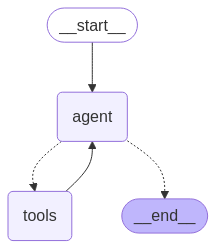

In [8]:
display(Image(graph.get_graph().draw_mermaid_png()))

Probamos el agente:

In [9]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

In [10]:
inputs = {"messages": [("user", "Podrías darme un resumen del CV de Bruno?")]}
print_stream(graph.stream(inputs, stream_mode="values", config=config))

================================ Human Message =================================

Podrías darme un resumen del CV de Bruno?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_bpx8)
 Call ID: call_bpx8
  Args:
    candidato: bruno
    query: resumen del CV
================================= Tool Message =================================
Name: retrieve

Source: {'author': 'Bruno Masoller', 'creationdate': '2025-04-08T18:48:43-03:00', 'creator': 'Microsoft® Word para Microsoft 365', 'moddate': '2025-04-08T18:48:43-03:00', 'producer': 'Microsoft® Word para Microsoft 365', 'source': '../resources/cv_candidatos/cv-bruno-masoller.pdf', 'total_pages': 4.0}
Content: o Año: 2024 - Actual 
o Lugar: https://brunomaso1.github.io/ml-porfolio/ 
o Organización: Proyecto propio. 
o Puesto: Especialista en Inteligencia Artificial. 
o Características:

Source: {'author': 'Bruno Masoller', 'creationdate': '2025-04-08T18:48:43-03:00', 'creator': 'Mi

In [37]:
inputs = {"messages": [("user", "De la experiencia en IA del candidato anterior, hay algún proyecto en particular?")]}
print_stream(graph.stream(inputs, stream_mode="values", config=config))

================================ Human Message =================================

De la experiencia en IA del candidato anterior, hay algún proyecto en particular?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_vgan)
 Call ID: call_vgan
  Args:
    candidato: bruno
    query: proyecto IA
================================= Tool Message =================================
Name: retrieve

Source: {'author': 'Bruno Masoller', 'creationdate': '2025-04-08T18:48:43-03:00', 'creator': 'Microsoft® Word para Microsoft 365', 'moddate': '2025-04-08T18:48:43-03:00', 'producer': 'Microsoft® Word para Microsoft 365', 'source': '../resources/cv_candidatos/cv-bruno-masoller.pdf', 'total_pages': 4.0}
Content: OTROS PROYECTOS: 
• Proyecto propio - Repositorio de la Maestría en Inteligencia Artificial 
o Año: 2024 - Actual 
o Lugar: https://github.com/brunomaso1/uba-mia 
o Organización: Proyecto propio.

Source: {'author': 'Bruno Masoller', 'crea

In [39]:
inputs = {"messages": [("user", "Podrías darme un resumen del CV de Jose?")]}
print_stream(graph.stream(inputs, stream_mode="values", config=config))

================================ Human Message =================================

Podrías darme un resumen del CV de Jose?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_fma2)
 Call ID: call_fma2
  Args:
    candidato: jose
    query: CV
================================= Tool Message =================================
Name: retrieve

Source: {'author': 'Bruno Masoller', 'creationdate': '2025-04-17T21:16:17-03:00', 'creator': 'Microsoft® Word para Microsoft 365', 'moddate': '2025-04-17T21:16:17-03:00', 'producer': 'Microsoft® Word para Microsoft 365', 'source': '../resources/cv_candidatos/cv-jose-martinez.pdf', 'total_pages': 3.0}
Content: Gestión eficaz del tiempo 
  Informes financieros 
 
EXPERIENCIA LABORAL 
  * febrero 2015 – mayo 2023 
    Contador Senior en Rodríguez; Asociados Contadores, Valdivia

Source: {'author': 'Bruno Masoller', 'creationdate': '2025-04-17T21:16:17-03:00', 'creator': 'Microsoft® Word para Micros

In [40]:
inputs = {"messages": [("user", "Podrías darme un resumen del CV de Manuel?")]}
print_stream(graph.stream(inputs, stream_mode="values", config=config))

================================ Human Message =================================

Podrías darme un del CV de Manuel?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_4nj0)
 Call ID: call_4nj0
  Args:
    candidato: manuel
    query: CV
================================= Tool Message =================================
Name: retrieve

Error: 1 validation error for retrieve
candidato
  Input should be 'bruno' or 'jose' [type=literal_error, input_value='manuel', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/literal_error
 Please fix your mistakes.
================================== Ai Message ==================================

Lo siento, pero no tengo información sobre un candidato llamado Manuel. Solo tengo información sobre los candidatos "bruno" y "jose". Si necesitas información sobre uno de ellos, puedo intentar ayudarte.


Inspeccionamos el historial de mensajes:

In [32]:
chat_history = graph.get_state(config).values["messages"]
for message in chat_history:
    message.pretty_print()

================================ Human Message =================================

Podrías darme un resumen del CV de Bruno?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_ehf7)
 Call ID: call_ehf7
  Args:
    candidato: bruno
    query: resumen del CV
================================= Tool Message =================================
Name: retrieve

Source: {'author': 'Bruno Masoller', 'creationdate': '2025-04-08T18:48:43-03:00', 'creator': 'Microsoft® Word para Microsoft 365', 'moddate': '2025-04-08T18:48:43-03:00', 'producer': 'Microsoft® Word para Microsoft 365', 'source': '../resources/cv_candidatos/cv-bruno-masoller.pdf', 'total_pages': 4.0}
Content: o Año: 2024 - Actual 
o Lugar: https://brunomaso1.github.io/ml-porfolio/ 
o Organización: Proyecto propio. 
o Puesto: Especialista en Inteligencia Artificial. 
o Características:

Source: {'author': 'Bruno Masoller', 'creationdate': '2025-04-08T18:48:43-03:00', 'creator': 'Mi

### Limpieza

In [11]:
# Eliminamos el índice
pc = Pinecone(api_key=PINECONE_API_KEY)
try:
    pc.delete_index(INDEX_NAME)
    print(f"Índice {INDEX_NAME} eliminado correctamente.")
except Exception as e:
    print(f"Error al eliminar el índice {INDEX_NAME}: {e}")

# Listamos los índices restantes
pc.list_indexes()

Índice nlp2-practico2 eliminado correctamente.


[]

### Streamlit
<small><em>https://shiv248.medium.com/langgraph-with-streamlit-intersection-0687995d1287</em></small>


In [ ]:
!streamlit run app.py

### Video de resolución

A continuación se muestra un video de la resolución del práctico, donde se puede ver el chatbot funcionando y respondiendo preguntas sobre el CV del alumno. El código de la aplicación se encuentra en: [codigo fuente](./app.py)

In [12]:
%%HTML
<video width="800"  controls>
  <source src="../resources/practico2.mp4" type="video/mp4">
</video>

### Video

### Mejoras futuras

Como posible mejoras:
- Hacer que el agente pregunte por el nombre del candidato si no se incluye en la pregunta.
- Probar con [Agentic RAG](https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_agentic_rag/#setup) - Retriever Agentic Graph (`create_retriever_tool`)
- Permitir subir CV de candidatos y crear el vectorstore automáticamente.